*Week 1 Velocity distributions:*

Background:
Irrespective of the start conditions, velocity distributions in multi-particle systems with
collisions between particles converge to a Maxwell-Boltzmann distribution. We will
investigate this effect by creating our own simulation of a multi-particle systems of
hard spheres in a 2D-box.

**Task I - Implementation**
In this first section will outline how we created an algorythm for simulating hard spheres in a box that includes 
* elastic collisions of hard spheres
* multi particle systems
* periodic boundary conditions for the box

All the code will be provided in easy to use functions that will be called for Task II.



Importing all external libraries used in this code

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import copy
import numpy as np
import scipy as scy

Creating a particle class:

In [2]:
class Particle:
    def __init__(self, r, x, y, vx, vy):
        self.r = r
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        
    def __repr__(self):
        return str("This is a particle at %0.2f, %0.2f with v=%0.2f,%0.2f" % (self.x,self.y,self.vx,self.vy))

Defining the parameters used in the simulation later on


In [3]:
# defining the box
box_size_x = 20
box_size_y = 20

box = [box_size_x,box_size_y]

In [4]:
# defining the number of particles and their corresponding radius
number_of_particles = 50
radius = 0.5

In [5]:
# Initialising the velocities
baseline_velocity = 0.5 # same velocity magnitude for all particles 

# random direction of the velocity in 2D for each particle
vel = np.ones(number_of_particles) * baseline_velocity
angles = np.random.uniform(0,2 * np.pi, number_of_particles)

In [6]:
# Initialising the positions
# random positions for each particle
x_rand = np.random.randint(1,box[0]-1,number_of_particles)
y_rand = np.random.randint(1,box[1]-1,number_of_particles)


In [7]:
# Setting up the particle:
# Each particle gets assigned a position (x,y) and a velocity (v_x, v_y).
particles = []
for i in range(number_of_particles):
    particles.append(Particle(radius,x_rand[i],y_rand[i],np.sin(angles[i]) * vel[i],np.cos(angles[i]) * vel[i]))

In [8]:
# Defining number of simulation steps
steps = 50

Initialise trajectory:

In [9]:
data_traj = np.zeros((number_of_particles,4,steps))
data_traj.shape

(50, 4, 50)

Euler integrator scheme:
Define time integrator for numerical, stepwise solution of equation of motion with a discrete time step $dt$:

In [10]:
# define time step dt for simulation
dt = 1

def move(p,dt):
    p.x = p.x + p.vx * dt
    p.y = p.y + p.vy * dt
    return p

Define a move function to move particles for each time step.

In [11]:
def move_unbound(p,dt):
    p.x = np.mod(p.x + p.vx * dt, box_size_x)
    p.y = np.mod(p.y + p.vy * dt, box_size_y)
    return p

Define box reflection:

In [12]:
def reflect(p):
    if (p.x + p.r) >= box[0]:
        p.vx = p.vx * (-1)
    if (p.x) <= p.r:
        p.vx = p.vx * (-1)
    if (p.y + p.r) >= box[1]:
        p.vy = p.vy * (-1)
    if (p.y) <= p.r:
        p.vy = p.vy * (-1)
    return p

Define a function that calculates new velocities for two particles (with the same mass) colliding with two different velocities in 2D. The formulas can be found here: 
 https://hermann-baum.de/elastischer_stoss/, 24.10.2024.


In [13]:
def collide_simple(particles):
    for i in range(len(particles)): # looping through all particles
        for j in range(len(particles)):
            if i < j:
                distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
                if distance<(particles[i].r+particles[j].r):
                    # calculate angle between x-axis and line between particles
                    phi = np.arctan((particles[j].y - particles[i].y)/(particles[j].x - particles[i].x))
                    # change the velocities
                    particles[i].vx = ( particles[i].vx*np.sin(phi)-particles[i].vy*np.cos(phi))*np.sin(phi)+(particles[j].vx*np.cos(phi)+particles[j].vy*np.sin(phi))*np.cos(phi)
                    particles[i].vy = (-particles[i].vx*np.sin(phi)+particles[i].vy*np.cos(phi))*np.cos(phi)+(particles[j].vx*np.cos(phi)+particles[j].vy*np.sin(phi))*np.sin(phi)
                    particles[j].vx = ( particles[j].vx*np.sin(phi)-particles[j].vy*np.cos(phi))*np.sin(phi)+(particles[i].vx*np.cos(phi)+particles[i].vy*np.sin(phi))*np.cos(phi)
                    particles[j].vy = (-particles[j].vx*np.sin(phi)+particles[j].vy*np.cos(phi))*np.cos(phi)+(particles[i].vx*np.cos(phi)+particles[i].vy*np.sin(phi))*np.sin(phi)
                    #print(particles[i],particles[j],'collided with a distance of ', distance)


The following algorithm works by checkin pariwise collisions. If there is a collision, defined by any overlap of two particles, the particles travel back in time, so that they are just touching. Then the new velocities are calculated whilst turning the coordinate system, to provide for easier calculation. Then the time is unwound forwards, considering the new velocities, so that each particle has the same time passed in one calculation step. When a particle is in the boundary of the box (close to 0 position on either axis), it is additionally checked for any particles that are on the opposite side of the box.

In [14]:
# https://hermann-baum.de/elastischer_stoss/
def calculate_distance(particle_1, particle_2):
    distance = np.sqrt(np.abs(particle_1.x - particle_2.x)**2+np.abs(particle_1.y - particle_2.y)**2)
    return distance


def collision(particles,data_traj,step, dt,i,j):
    distance_vector = np.array([particles[j].x-particles[i].x,particles[j].y-particles[i].y])# von i nach j
    distance = np.sqrt(np.abs(distance_vector[0])**2+np.abs(distance_vector[1])**2)
    R = particles[i].r+particles[j].r
    if distance<R:
        #print(step)
        print(particles[i],particles[j],'collided with a distance of ', distance)
        # angle between x-axis and line between particles
        phi = np.arctan((particles[j].y - particles[i].y)/(particles[j].x - particles[i].x))
        
        # in time
        # defining re-used variables
        v_x = particles[i].vx-particles[j].vx
        v_y = particles[i].vy-particles[j].vy

        r_x = particles[j].x-particles[i].x
        r_y = particles[j].y-particles[i].y

        #calculating the time needed to travel back in two steps:
        sqrt = 2*np.sqrt((r_x*v_x+r_y*v_y)**2-(v_x**2+v_y**2)*(r_x**2+r_y**2-R**2))
        
        delta_t = -1*(-2*(r_x*v_x+r_y*v_y) + sqrt)/(2*(v_x**2+v_y**2))
        
        #solving the quadratic equation results in two solutions (one positive and one negative), we want the negative solution, for backwards time-travel
        if delta_t > 0:
            delta_t = -1*(-2*(r_x*v_x+r_y*v_y) - sqrt)/(2*(v_x**2+v_y**2))

        # rewind time to just outside of the collision
        particles[i].x = particles[i].x + particles[i].vx*delta_t
        particles[i].y = particles[i].y + particles[i].vy*delta_t
        particles[j].x = particles[j].x + particles[j].vx*delta_t
        particles[j].y = particles[j].y + particles[j].vy*delta_t

        #debugging
        distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
        #print(particles[i],particles[j],'collided with a distance of ', distance)

        # used chatGPT for debugging
        # change the velocities

        # only calculate once, used multiple times
        sin_phi = np.sin(phi)
        cos_phi = np.cos(phi)

        # Get the velocities of particles i and j as variables
        v1x, v1y = particles[i].vx, particles[i].vy
        v2x, v2y = particles[j].vx, particles[j].vy

        # Calculate the updated velocities using the provided formulas: https://hermann-baum.de/elastischer_stoss/
        # the tangental part stays the same, the normal part changes. This is done in transformed coordinates and then transformed directly back
        new_v1x = (v1x * sin_phi - v1y * cos_phi) * sin_phi + (v2x * cos_phi + v2y * sin_phi) * cos_phi
        new_v1y = (-v1x * sin_phi + v1y * cos_phi) * cos_phi + (v2x * cos_phi + v2y * sin_phi) * sin_phi
        new_v2x = (v2x * sin_phi - v2y * cos_phi) * sin_phi + (v1x * cos_phi + v1y * sin_phi) * cos_phi
        new_v2y = (-v2x * sin_phi + v2y * cos_phi) * cos_phi + (v1x * cos_phi + v1y * sin_phi) * sin_phi

        # Update the particles' velocities
        particles[i].vx, particles[i].vy = new_v1x, new_v1y
        particles[j].vx, particles[j].vy = new_v2x, new_v2y
        
        # just for debugging
        distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
        #print(particles[i],particles[j],'collided with a distance of ', distance)

        # finish this time_step, that was rewound previously and open the boundaries again with np.mod
        particles[i].x = np.mod(particles[i].x - particles[i].vx*delta_t,box_size_x)
        particles[i].y = np.mod(particles[i].y - particles[i].vy*delta_t,box_size_y)
        particles[j].x = np.mod(particles[j].x - particles[j].vx*delta_t,box_size_x)
        particles[j].y = np.mod(particles[j].y - particles[j].vy*delta_t,box_size_y)
        # debugging
        distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
        #print(particles[i],particles[j],'collided with a distance of ', distance)

def collide_border(particles,data_traj,step, dt,i,x):
    # set particle to the opposite box
    if x:
        pos_x = particles[i].x+box_size_x
    else:
        pos_y = particles[i].y+box_size_y
    # check for collisions
    for j in range(len(particles)):
        if i < j:
            collision(particles,data_traj,step, dt, i, j)
            

def collide_boundary(particles,data_traj,step, dt):
    #run through all pairwise possible interactions and check collisions
    for i in range(len(particles)):
        for j in range(len(particles)):
            if i < j:
                collision(particles,data_traj,step, dt, i, j)
        # account for edge cases
        if particles[i].x<particles[i].r:
            collide_border(particles,data_traj,step, dt,i,True)
        if particles[i].y<particles[i].r:
            collide_border(particles,data_traj,step, dt,i,False)
                    

**Task II - Carrying out the simulation**
In the following the above functions will be implemented to run a simulation.

The actual integration happens here. Everything is saved to the predefined data_traj-array


In [15]:

for i in range(steps):
    for j in range(number_of_particles):
        #move(p1,1)
        #reflect(p1)
        move_unbound(particles[j],1)
        collide_boundary(particles,data_traj,i,dt)    
        for j in range(number_of_particles):
            data_traj[j,:,i] = [particles[j].x, particles[j].y, particles[j].vx, particles[j].vy]
        

This is a particle at 13.50, 9.98 with v=-0.50,-0.02 This is a particle at 14.00, 10.00 with v=-0.22,0.45 collided with a distance of  0.4999999999999999
This is a particle at 11.00, 10.00 with v=0.26,0.43 This is a particle at 11.00, 10.00 with v=0.12,-0.49 collided with a distance of  0.0
This is a particle at 8.00, 8.00 with v=0.47,-0.18 This is a particle at 8.00, 8.00 with v=0.15,-0.48 collided with a distance of  0.0
This is a particle at 1.00, 11.00 with v=0.04,0.50 This is a particle at 1.00, 11.00 with v=-0.40,-0.30 collided with a distance of  0.0
This is a particle at 14.14, 10.01 with v=-0.21,-0.01 This is a particle at 13.36, 9.97 with v=-0.52,0.43 collided with a distance of  0.7785762378025558
This is a particle at 13.50, 9.98 with v=-0.50,-0.02 This is a particle at 14.00, 10.00 with v=-0.22,0.45 collided with a distance of  0.4999999999999999
This is a particle at 14.14, 10.01 with v=-0.21,-0.01 This is a particle at 13.36, 9.97 with v=-0.52,0.43 collided with a distan

<ipython-input-14-3c5d6bd23bf5>:15: RuntimeWarning: invalid value encountered in long_scalars
  phi = np.arctan((particles[j].y - particles[i].y)/(particles[j].x - particles[i].x))


 This is a particle at 6.31, 18.40 with v=-0.12,-0.11 collided with a distance of  0.6850130460975608
This is a particle at 6.21, 18.46 with v=0.21,0.46 This is a particle at 7.00, 18.00 with v=0.34,-0.37 collided with a distance of  0.9160675111786637
This is a particle at 6.90, 18.06 with v=0.66,0.19 This is a particle at 6.31, 18.40 with v=-0.12,-0.11 collided with a distance of  0.6850130460975608
This is a particle at 6.21, 18.46 with v=0.21,0.46 This is a particle at 7.00, 18.00 with v=0.34,-0.37 collided with a distance of  0.9160675111786637
This is a particle at 6.90, 18.06 with v=0.66,0.19 This is a particle at 6.31, 18.40 with v=-0.12,-0.11 collided with a distance of  0.6850130460975608
This is a particle at 6.21, 18.46 with v=0.21,0.46 This is a particle at 7.00, 18.00 with v=0.34,-0.37 collided with a distance of  0.9160675111786637
This is a particle at 6.90, 18.06 with v=0.66,0.19 This is a particle at 6.31, 18.40 with v=-0.12,-0.11 collided with a distance of  0.685013

The following code is just for visualisation purposes.

Plotting trajectory with Matplotlib:

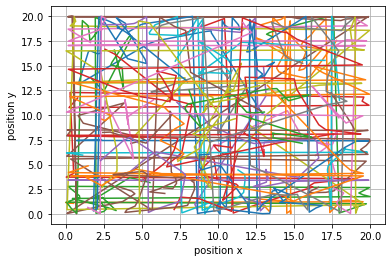

In [16]:
for data_traj_j in data_traj:
    plt.plot(data_traj_j[0],data_traj_j[1],'-')
plt.xlabel('position x')
plt.ylabel('position y')

plt.grid()
plt.show()

**Animate trajectory:**

* Set up the figure, the axis, and the plot element we want to animate

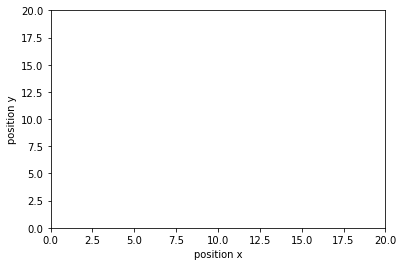

In [17]:
fig, ax = plt.subplots()

ax.set_xlim((0, box[0]))
ax.set_ylim((0, box[1]))

plt.xlabel('position x')
plt.ylabel('position y')

# make the points in the plot the correct size according to the radius of the particles
# use ax.transData.transform to convert radius size from particle to markerSize from pyplot
desired_size_in_data_units = radius
data_to_points = ax.transData.transform((desired_size_in_data_units, 0)) - ax.transData.transform((0, 0))
marker_size_in_points = data_to_points[0]


dot, = ax.plot([], [], 'bo', ms=marker_size_in_points)


#ax.plot(5,5, 'bo', ms=marker_size_in_points)
# dont show the plot 
#plt.close()

In [18]:
# * initialization function: plot the background of each frame
def init():
    dot.set_data([], [])
    return (dot,)

In [19]:
# animation function. This is called sequentially
def animate(i):
    x = data_traj[:,0,i]
    y = data_traj[:,1,i]
    dot.set_data(x, y)
    return (dot,)


* call the animator. blit=True means only re-draw the parts that have changed.

In [20]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=steps, interval=60, blit=True)

In [21]:
HTML(anim.to_html5_video())

# uncomment if video should not be saved
anim.save('animation.mp4', writer='ffmpeg', fps=30)


***Task III - analysis of the velocity distributions:***

Finally the results from the above simulation can be analysed.

Analysis of the velocity distribution in x direction
In order to plot a histogram the data saved in the data_traj has to be transformed into a list.

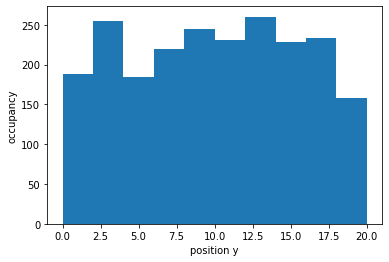

In [28]:
# format of data_traj:

list_for_histogramm = []
for i in range(steps):
    for j in range(number_of_particles):
        list_for_histogramm.append((data_traj)[j, 0, i])

plt.hist(list_for_histogramm,range=(0,box[0]),bins=10)
plt.xlabel('position x')
plt.ylabel('occupancy')
plt.show()

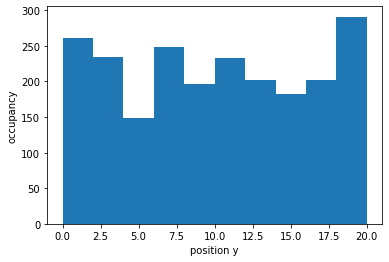

In [22]:
# histogram of the y positions

list_for_histogramm = []
for i in range(steps):
    for j in range(number_of_particles):
        list_for_histogramm.append((data_traj)[j, 1, i])

plt.hist(list_for_histogramm,range=(0,box[0]),bins=10)
plt.xlabel('position y')
plt.ylabel('occupancy')
plt.show()

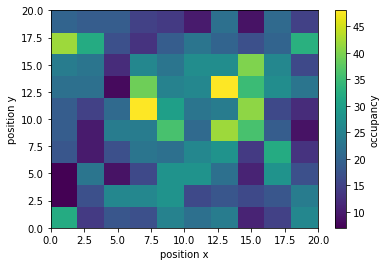

In [30]:
# 2d plot of the position distribution

a = []
for i in range(steps):
    for j in range(number_of_particles):
        a.append((data_traj)[j, 0, i])
b = []
for i in range(steps):
    for j in range(number_of_particles):
        b.append((data_traj)[j, 1, i])
    

plt.hist2d(a, b, range=[[0,box[0]],[0,box[1]]], bins=10)
plt.xlabel('position x')
plt.ylabel('position y')
plt.colorbar().set_label('occupancy')
plt.show()

In the above plots it can be observed that whilst the simple histograms of x and y distribution show an evenly spread distribution, in 2D the box is not homogeniously sampled. Certain spots show a significantly higher occupancy than others. This is clearly a limitation.

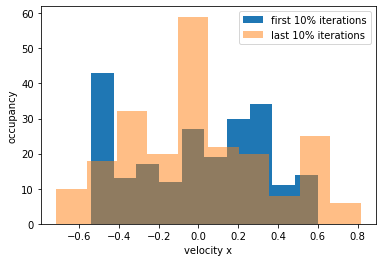

In [29]:
# comparison of different iteration parts

# first 10%
a = []
for i in range(np.int(0.1 *steps)):
    for j in range(number_of_particles):
        a.append(data_traj[j,2,i])

# last 10%
b = []
i_0 = np.int(0.9 * steps)-1
for i in range(np.int(0.1 * steps)):
    i = i+i_0
    
    for j in range(number_of_particles):
        b.append(data_traj[j,2,i])
    i = i+1

plt.hist(a,bins=10, label = 'first 10% iterations')
plt.hist(b,bins=10, label = 'last 10% iterations', alpha=0.5)
plt.xlabel('velocity x')
plt.ylabel('occupancy')
plt.legend()
plt.show()


Analysis of the velocity distribution in the x direction

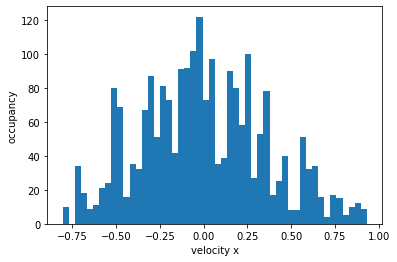

In [32]:
# plt.hist(data_traj[1],range=(0,box[1]),bins=3)
# plt.xlabel('position y')
# plt.ylabel('occupancy')
# plt.show()

# histogram of the x velocity

a = []
for i in range(steps):
    for j in range(number_of_particles):
        a.append((data_traj)[j, 2, i])
    
plt.hist(a,bins=50)
plt.xlabel('velocity x')
plt.ylabel('occupancy')
plt.show()

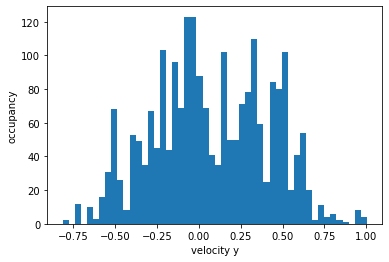

In [33]:
# histogram of the y velocity

a = []
for i in range(steps):
    for j in range(number_of_particles):
        a.append((data_traj)[j, 3, i])
    
plt.hist(a,bins=50)
plt.xlabel('velocity y')
plt.ylabel('occupancy')
plt.show()

In [26]:
# Maxwell Boltzmann Distribution
def mwb_dist(vs, const):
    # const = kT / m
    return 4 * np.pi * (2 * np.pi * const)**(-3/2) * vs**2 * np.exp(-0.5 * vs**2 / const)

10.005660593999018
-0.20565822342547566
9.99729584444093
-0.20565822342547566
9.988931094882844
-0.20565822342547566
9.980566345324757
-0.20565822342547566
9.97220159576667
-0.20565822342547566
9.963836846208583
-0.20565822342547566
10.181665404177703
-0.2377822323239402
10.762751119763871
-0.2377822323239402
11.34383683535004
-0.2377822323239402
11.924922550936207
-0.2377822323239402
12.506008266522375
-0.2377822323239402
13.087093982108543
-0.2377822323239402
13.668179697694711
-0.2377822323239402
14.24926541328088
-0.2377822323239402
14.830351128867047
-0.2377822323239402
15.411436844453215
-0.2377822323239402
15.992522560039383
-0.2377822323239402
16.57360827562555
-0.2377822323239402
17.154693991211715
-0.2377822323239402
17.73577970679788
-0.2377822323239402
18.316865422384048
-0.2377822323239402
18.516480888519855
0.01658966611881904
18.455672083034653
-0.5404351112851625
18.298273922893785
-0.5404351112851625
18.140875762752916
-0.5404351112851625
17.983477602612048
-0.54043511

ValueError: autodetected range of [nan, nan] is not finite

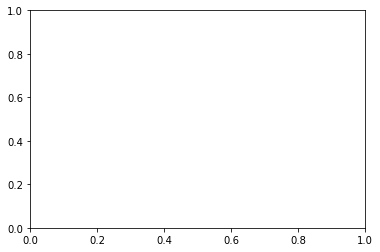

In [40]:
# Histogram of |velocity|

######################################
NOT WORKING!
######################################

i = 0
all_velocities = []
for i in range(steps):
    for j in range(number_of_particles):
        print(data_traj[i, 1, j])
        print(data_traj[i, 2, j])
        
        velocity = np.sqrt((data_traj[i, 1, j])**2 + (data_traj[i, 2, j])**2) 
        # all_velocities.append(velocity)


plt.hist(velocity,bins=100)
plt.xlabel('velocity |v|')
plt.ylabel('occupancy')
plt.show()



Analysis of the velocity distribution in the xy Plane

**Interpretation:**
* in the reduced data projection, the occupancy of each bin seems even and well-distributed
* in the full dimensional projection, it can be seen easily that the box is **not** fully sampled, large undersampled patches present
* *data dimensionality reduction always brings the danger of wrong projection!*

**Solution for improvements:**
* enhance sampling by
    * prolong the simulation
    * increase the time step
* *Caveat: all solutions come with problems like increased computational cost or sampling errors!*